In [ ]:
# Define some helper functions for downloading pretrained model
# taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
# download and unzip...
def download_all():
    file_id = '1DAmlftwj9UEOI1S2J1YycnUtM392Sk6d'
    destination = './data/ModelNet40_PLY.zip'
    download_file_from_google_drive(file_id, destination)

    file_id = '1KlhouSbf7j3lpKWUb5l6Y0K74MNf0Fen'
    destination = './data/ModelNet10_PLY.zip'
    download_file_from_google_drive(file_id, destination)

# Launch at starting session
download_all()
!unzip ./data/ModelNet40_PLY.zip -d ./data/
!unzip ./data/ModelNet10_PLY.zip -d ./data/

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0035.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0036.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0037.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0038.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0039.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0040.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0041.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0042.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0043.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0044.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0045.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0046.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0047.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_0048.ply  
  inflating: ./data/ModelNet40_PLY/xbox/train/xbox_004

In [ ]:
#
#
#      0===========================================================0
#      |       TP6 PointNet for point cloud classification         |
#      0===========================================================0
#
#
# ------------------------------------------------------------------------------------------
#
#      Jean-Emmanuel DESCHAUD - 12/01/2021
#

import numpy as np
import random
import math
import os
import time
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F

# Import functions to read and write ply files
from ply import write_ply, read_ply

In [ ]:
def rand_rotation_matrix(deflection=1.0, randnums=None):
    """
    Creates a random rotation matrix.
    
    deflection: the magnitude of the rotation. For 0, no rotation; for 1, competely random
    rotation. Small deflection => small perturbation.
    randnums: 3 random numbers in the range [0, 1]. If `None`, they will be auto-generated.
    """
    # from http://www.realtimerendering.com/resources/GraphicsGems/gemsiii/rand_rotation.c
    
    if randnums is None:
        randnums = np.random.uniform(size=(3,))
        
    theta, phi, z = randnums
    
    theta = theta * 2.0*deflection*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0*deflection  # For magnitude of pole deflection.
    
    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.
    
    r = np.sqrt(z)
    Vx, Vy, Vz = V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
        )
    
    st = np.sin(theta)
    ct = np.cos(theta)
    
    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))
    
    # Construct the rotation matrix  ( V Transpose(V) - I ) R.
    
    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M

In [ ]:
class RandomRotation_z(object):
    def __call__(self, pointcloud):
        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),      0],
                               [ math.sin(theta),  math.cos(theta),      0],
                               [0,                               0,      1]])
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return rot_pointcloud

class RandomScaling(object):
    def __call__(self, pointcloud):
        scale = 0.5 + 10 * random.random()
        scale_matrix = scale * np.eye(3)
        scaled_pointcloud = scale_matrix.dot(pointcloud.T).T
        return scaled_pointcloud

class RandomRotation(object):
    def __init__(self, deflection):
        self.deflection = deflection

    def __call__(self, pointcloud):
        rot_matrix = rand_rotation_matrix(deflection=self.deflection)
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return rot_pointcloud

class RandomRotation_z(object):
    def __call__(self, pointcloud):
        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),      0],
                               [ math.sin(theta),  math.cos(theta),      0],
                               [0,                               0,      1]])
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return rot_pointcloud

class RandomNoise(object):
    def __call__(self, pointcloud):
        noise = np.random.normal(0, 0.02, (pointcloud.shape))
        noisy_pointcloud = pointcloud + noise
        return noisy_pointcloud

class ShufflePoints(object):
    def __call__(self, pointcloud):
        np.random.shuffle(pointcloud)
        return pointcloud

class ToTensor(object):
    def __call__(self, pointcloud):
        return torch.from_numpy(pointcloud)


def default_transforms():
    # return transforms.Compose([RandomRotation(),RandomNoise(),ShufflePoints(),ToTensor()])
    return transforms.Compose([RandomRotation_z(),RandomNoise(),ShufflePoints(),ToTensor()])


class PointCloudData(Dataset):
    def __init__(self, root_dir, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir+"/"+dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir+"/"+category+"/"+folder
            for file in os.listdir(new_dir):
                if file.endswith('.ply'):
                    sample = {}
                    sample['ply_path'] = new_dir+"/"+file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        ply_path = self.files[idx]['ply_path']
        category = self.files[idx]['category']
        data = read_ply(ply_path)
        pointcloud = self.transforms(np.vstack((data['x'], data['y'], data['z'])).T)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}



class PointMLP(nn.Module):
    def __init__(self, classes = 40):
        super().__init__()
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)

        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        x = self.flatten(input)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return self.logsoftmax(x)


class PointNetBasic(nn.Module):
    def __init__(self, classes = 40):
        super().__init__()
        self.flatten = nn.Flatten()

        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 64, 1)
        self.conv3 = torch.nn.Conv1d(64, 64, 1)
        self.conv4 = torch.nn.Conv1d(64, 128, 1)
        self.conv5 = torch.nn.Conv1d(128, 1024, 1)

        self.maxpool = nn.MaxPool1d(1024)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)

        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(1024)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(256)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):

        x = F.relu(self.bn1(self.conv1(input)))
        x = F.relu(self.bn2(self.conv2(x)))

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))

        x = self.maxpool(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn6(self.fc1(x)))
        x = F.relu(self.bn7(self.dropout(self.fc2(x))))
        x = self.fc3(x)

        return self.logsoftmax(x)
        
        
        
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)

        self.maxpool = nn.MaxPool1d(1024)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, input):
        x = F.relu(self.bn1(self.conv1(input)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = self.maxpool(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        id3x3 = torch.eye(self.k, requires_grad=True).flatten().repeat(x.shape[0], 1)
        if x.is_cuda:
            id3x3 = id3x3.cuda()
        x = x + id3x3
        x = x.view(-1, self.k, self.k)

        return x


class PointNetFull(nn.Module):
    def __init__(self, classes = 40):
        super().__init__()

        self.tnet = Tnet(k=3)

        self.flatten = nn.Flatten()

        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 64, 1)
        self.conv3 = torch.nn.Conv1d(64, 64, 1)
        self.conv4 = torch.nn.Conv1d(64, 128, 1)
        self.conv5 = torch.nn.Conv1d(128, 1024, 1)

        self.maxpool = nn.MaxPool1d(1024)

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)

        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(1024)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(256)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):

        tmat = self.tnet(input)
        x = torch.matmul(tmat, input)

        x = F.relu(self.bn1(self.conv1(input)))
        x = F.relu(self.bn2(self.conv2(x)))

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))

        x = self.maxpool(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn6(self.fc1(x)))
        x = F.relu(self.bn7(self.dropout(self.fc2(x))))
        x = self.fc3(x)

        return self.logsoftmax(x), tmat


def basic_loss(outputs, labels):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    return criterion(outputs, labels)

def pointnet_full_loss(outputs, labels, m3x3, alpha = 0.001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)) / float(bs)


def train(model, device, train_loader, test_loader=None, epochs=250):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    val_accs = []
    loss=0
    for epoch in range(epochs): 
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs.transpose(1,2))
            # outputs, m3x3 = model(inputs.transpose(1,2))
            loss = basic_loss(outputs, labels)
            # loss = pointnet_full_loss(outputs, labels, m3x3)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = total = 0
        if test_loader:
            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs = model(inputs.transpose(1,2))
                    # outputs, __ = model(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            val_accs.append(val_acc)
            print('Epoch: %d, Loss: %.3f, Test accuracy: %.1f %%' %(epoch+1, loss, val_acc))

        scheduler.step()
    return val_accs

In [ ]:
t0 = time.time()
    
train_ds = PointCloudData("./data/ModelNet40_PLY")
test_ds = PointCloudData("./data/ModelNet40_PLY", folder='test')

inv_classes = {i: cat for cat, i in train_ds.classes.items()}
print("Classes: ", inv_classes)
print('Train dataset size: ', len(train_ds))
print('Test dataset size: ', len(test_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=32)

# model = PointMLP()
model = PointNetBasic()
# model = PointNetFull()

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("Number of parameters in the Neural Networks: ", sum([np.prod(p.size()) for p in model_parameters]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("Device: ", device)
model.to(device);

valaccs_1 = train(model, device, train_loader, test_loader, epochs = 50)

print("Total time for training : ", time.time()-t0)

Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Number of parameters in the Neural Networks:  819624
Device:  cuda:0
Epoch: 1, Loss: 1.110, Test accuracy: 56.0 %
Epoch: 2, Loss: 1.203, Test accuracy: 72.5 %
Epoch: 3, Loss: 0.816, Test accuracy: 72.6 %
Epoch: 4, Loss: 0.896, Test accuracy: 72.3 %
Epoch: 5, Loss: 0.804, Test accuracy: 68.8 %
Epoch: 6, Loss: 0.971, Test 

In [ ]:
t0 = time.time()
    
def default_transforms():
    return transforms.Compose([RandomScaling(),RandomNoise(),ShufflePoints(),ToTensor()])
    # return transforms.Compose([RandomRotation_z(),RandomNoise(),ShufflePoints(),ToTensor()])
    
train_ds = PointCloudData("./data/ModelNet40_PLY", transform=default_transforms())
test_ds = PointCloudData("./data/ModelNet40_PLY", transform=default_transforms(), folder='test')

inv_classes = {i: cat for cat, i in train_ds.classes.items()}
print("Classes: ", inv_classes)
print('Train dataset size: ', len(train_ds))
print('Test dataset size: ', len(test_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=32)

def train(model, device, train_loader, test_loader=None, epochs=250):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    val_accs = []
    loss=0
    for epoch in range(epochs): 
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs.transpose(1,2))
            # outputs, m3x3 = model(inputs.transpose(1,2))
            loss = basic_loss(outputs, labels)
            # loss = pointnet_full_loss(outputs, labels, m3x3)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = total = 0
        if test_loader:
            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs = model(inputs.transpose(1,2))
                    # outputs, __ = model(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            val_accs.append(val_acc)
            print('Epoch: %d, Loss: %.3f, Test accuracy: %.1f %%' %(epoch+1, loss, val_acc))

        scheduler.step()
    return val_accs

model = PointNetBasic()

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("Number of parameters in the Neural Networks: ", sum([np.prod(p.size()) for p in model_parameters]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("Device: ", device)
model.to(device);

valaccs_2 = train(model, device, train_loader, test_loader, epochs = 100)

print("Total time for training : ", time.time()-t0)

Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Number of parameters in the Neural Networks:  819624
Device:  cuda:0
Epoch: 1, Loss: 1.820, Test accuracy: 58.6 %
Epoch: 2, Loss: 0.594, Test accuracy: 58.2 %
Epoch: 3, Loss: 0.784, Test accuracy: 71.6 %
Epoch: 4, Loss: 0.711, Test accuracy: 66.7 %
Epoch: 5, Loss: 0.778, Test accuracy: 68.1 %
Epoch: 6, Loss: 0.656, Test 

In [ ]:
t0 = time.time()
    
def default_transforms():
    return transforms.Compose([RandomRotation(0.3),RandomNoise(),ShufflePoints(),ToTensor()])
    # return transforms.Compose([RandomRotation_z(),RandomNoise(),ShufflePoints(),ToTensor()])
    
train_ds = PointCloudData("./data/ModelNet40_PLY", transform=default_transforms())
test_ds = PointCloudData("./data/ModelNet40_PLY", transform=default_transforms(), folder='test')

inv_classes = {i: cat for cat, i in train_ds.classes.items()}
print("Classes: ", inv_classes)
print('Train dataset size: ', len(train_ds))
print('Test dataset size: ', len(test_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=32)

def train(model, device, train_loader, test_loader=None, epochs=250):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    val_accs = []
    loss=0
    for epoch in range(epochs): 
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            # outputs = model(inputs.transpose(1,2))
            outputs, m3x3 = model(inputs.transpose(1,2))
            # loss = basic_loss(outputs, labels)
            loss = pointnet_full_loss(outputs, labels, m3x3)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = total = 0
        if test_loader:
            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    # outputs = model(inputs.transpose(1,2))
                    outputs, __ = model(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            val_accs.append(val_acc)
            print('Epoch: %d, Loss: %.3f, Test accuracy: %.1f %%' %(epoch+1, loss, val_acc))

        scheduler.step()
    return val_accs

model = PointNetFull()

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("Number of parameters in the Neural Networks: ", sum([np.prod(p.size()) for p in model_parameters]))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("Device: ", device)
model.to(device);

valaccs_3 = train(model, device, train_loader, test_loader, epochs = 100)

print("Total time for training : ", time.time()-t0)

Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Number of parameters in the Neural Networks:  1622705
Device:  cuda:0
Epoch: 1, Loss: 2.342, Test accuracy: 35.4 %
Epoch: 2, Loss: 0.989, Test accuracy: 45.9 %
Epoch: 3, Loss: 1.712, Test accuracy: 51.7 %
Epoch: 4, Loss: 1.531, Test accuracy: 45.6 %
Epoch: 5, Loss: 1.047, Test accuracy: 43.2 %
Epoch: 6, Loss: 0.999, Test

In [ ]:
import matplotlib.pyplot as plt

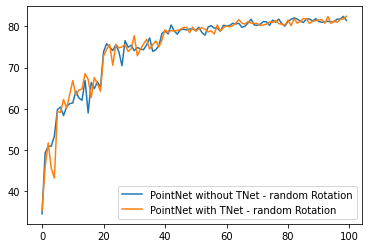

In [ ]:
plt.plot(valaccs_2, label="PointNet without TNet - random Rotation")
plt.plot(valaccs_3, label="PointNet with TNet - random Rotation")
plt.legend()
plt.show()

In [ ]:
max(valaccs_1),max(valaccs_2),max(valaccs_3)

(16.977309562398702, 85.49432739059968, 86.10210696920583)

In [ ]:
! git clone https://github.com/NVIDIA/MinkowskiEngine

Cloning into 'MinkowskiEngine'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 6915 (delta 78), reused 73 (delta 31), pack-reused 6766
Receiving objects: 100% (6915/6915), 14.62 MiB | 21.63 MiB/s, done.
Resolving deltas: 100% (5446/5446), done.


In [ ]:
%cd MinkowskiEngine/

/content/MinkowskiEngine


In [ ]:
!pip install -U MinkowskiEngine --install-option="--blas=openblas" -v --no-deps 

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-iegtg94u
Created temporary directory: /tmp/pip-req-tracker-be61vixc
Created requirements tracker '/tmp/pip-req-tracker-be61vixc'
Created temporary directory: /tmp/pip-install-nrmqg_h6
1 location(s) to search for versions of MinkowskiEngine:
* https://pypi.org/simple/minkowskiengine/
Getting page https://pypi.org/simple/minkowskiengine/
Found index url https://pypi.org/simple
Looking up "https://pypi.org/simple/minkowskiengine/" in the cache
Request header has "max_age" as 0, cache bypassed
Starting new HTTPS connection (1): pypi.org:443
https://pypi.org:443 "GET /simple/minkowskiengine/ HTTP/1.1" 200 1580
Updating cache with response from "https://pypi.org/simple/minkowskiengine/"
Caching due 

In [ ]:
!pip install open3d

     |████████████████████████████████| 188.4MB 84kB/s 


In [ ]:
!python -m examples.classification_modelnet40 --network pointnet

===================ModelNet40 Dataset===================
Training with translation 0.2
Evaluating with translation 0.0


===================Network===================
ResFieldNet14(
  (field_network): Sequential(
    (0): MinkowskiSinusoidal()
    (1): MinkowskiBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiReLU()
    (3): MinkowskiLinear(in_features=32, out_features=32, bias=True)
    (4): MinkowskiBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MinkowskiReLU()
    (6): MinkowskiToSparseTensor()
  )
  (field_network2): Sequential(
    (0): MinkowskiSinusoidal()
    (1): MinkowskiBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiReLU()
    (3): MinkowskiLinear(in_features=64, out_features=64, bias=True)
    (4): MinkowskiBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MinkowskiReLU()
    (6): MinkowskiToSparseTensor